In [2]:
%matplotlib inline
from pylab import *
import numpy.random as rnd
import csv

Load model parameters:

In [44]:
!python 'parameters.py'

In [45]:
pmin = 0 # lower bound of parameter range
pmax = 100 # upper bound of parameter range
M = 25 # number of grid points in parameter range
paramvec = linspace(pmin,pmax,M) # this is the set of parameter values you want to search
TTP = zeros((M,101)) # matrix of TTP as a function of (param, drug dose)

In [46]:
# finite difference matrix (order 3) for approximating del(TTP)/del(drug dose): (Um*TTP^T)^T = TTP*Um^T
Um = zeros((101,101))
Um[0,0] = -1.5; Um[0,1] = 2; Um[0,2] = -0.5;
Um[100,98] = 0.5; Um[100,99] = -2; Um[100,100] = 1.5;
for ii in range(1,100):
    Um[ii,ii-1] = -0.5
    Um[ii,ii+1] = 0.5

# finite difference matrix (order 2) for approximating del(TTP)/del(param): Up*TTP
delp = paramvec[1]-paramvec[0]
Up = zeros((M,M))
Up[0,0] = -1.5/delp; Up[0,1] = 2/delp; Up[0,2] = -0.5/delp;
Up[M-1,M-3] = 0.5/delp; Up[M-1,M-2] = -2/delp; Up[M-1,M-1] = 1.5/delp;
for ii in range(1,M-1):
    Up[ii,ii-1] = -0.5/delp
    Up[ii,ii+1] = 0.5/delp

In [47]:
# function that computes TTP using exact solution of ODE
def t_P_fun(m):
    V = [[vec1(m), vec2(m)],[1,1]] # eigenvalues
    c = inv(V).dot(x0) # constants in exact solution
    t = linspace(0,200,num = 10000)
    xtrue = zeros((2,len(t))) # exact solution to ODE
    for j in range(1,len(t)):
        if c[0]*exp(lam1(m)*t[j])*(vec1(m)+1) + c[1]*exp(lam2(m)*t[j])*(vec2(m)+1) > x0[0]+x0[1]:
            break
    return t[j]

In [48]:
for jj in range(M):
    PSR = paramvec[jj] # rename left-hand side as parameter you are searching over
    TTP[jj,:] = np.array(list(map(t_P_fun, range(101)))) # compute TTP(m) for paramvec[jj]

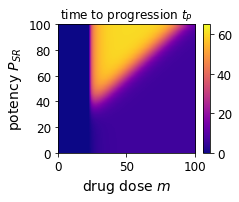

In [42]:
cm = 1/2.54 # for converting figure size to centimeters

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)

fig = plt.figure(figsize=(7.8*cm,6*cm))
plt.imshow(np.flip(TTP, axis=0),cmap="plasma",vmin=0, vmax=65,interpolation='bilinear',extent=[0,100,pmin,pmax],aspect='auto')
plt.colorbar()
plt.xlabel(r"drug dose $m$")
plt.ylabel(r"potency $P_{SR}$")
plt.title(r"time to progression $t_P$")

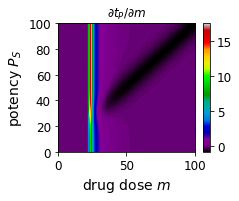

In [9]:
fig = plt.figure(figsize=(7.8*cm,6*cm))
plt.imshow(np.flip(TTP.dot(Um.T),axis=0),cmap="nipy_spectral",interpolation='bilinear',extent=[0,100,pmin,pmax],aspect='auto')
plt.colorbar()
plt.xlabel(r"drug dose $m$")
plt.ylabel(r"potency $P_S$")
plt.title(r"$\partial t_P/\partial m$")

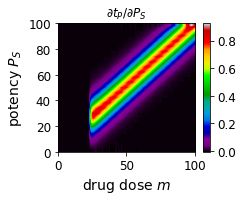

In [10]:
fig = plt.figure(figsize=(7.8*cm,6*cm))
plt.imshow(np.flip(Up.dot(TTP),axis=0),cmap="nipy_spectral",interpolation='bilinear',extent=[0,100,pmin,pmax],aspect='auto')
plt.colorbar()
plt.xlabel(r"drug dose $m$")
plt.ylabel(r"potency $P_S$")
plt.title(r"$\partial t_P/\partial P_S$")